Первый пункт задания - скачать dataset. Выполнить его можно несколькими способами:
1. Зайти на [pyTorch Datsets](https://pytorch.org/vision/stable/datasets.html), там сделать поиск по ключевому слову **FashionMNIST**, перейти по [следующей ссылке](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) и увидеть пример импорта:
    ```py
    torchvision.datasets.FashionMNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
    ```
2. Скачать dataset [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) с kaggle.

Я преподчитаю 2-ой вариант, поэтому скачал непосредсвенно весь датасет в виде файлов и положил его в папку **dataset**.

In [1]:
import time

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='dark')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')
print(f'Версия pytorch: {torch.__version__}')

Устройство: cuda
Версия pytorch: 2.3.0.dev20240105+cu121


### Доп. функции визуализации и тренировки нейронной сети

In [2]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None

):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        if scheduler != None:
            scheduler.step()

        plot_learning_curves(history)
        
    return model, history

### Рассмотрим вариант DNN, описанной в вебинаре

In [3]:
batch_size = 256

train_dataset = torchvision.datasets.FashionMNIST('./dataset/', train=True, transform=torchvision.transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.FashionMNIST('./dataset/', train=False, transform=torchvision.transforms.ToTensor(), download=False)
train_batch = torch.utils.data.DataLoader(train_dataset, batch_size)
test_batch = torch.utils.data.DataLoader(test_dataset, batch_size)

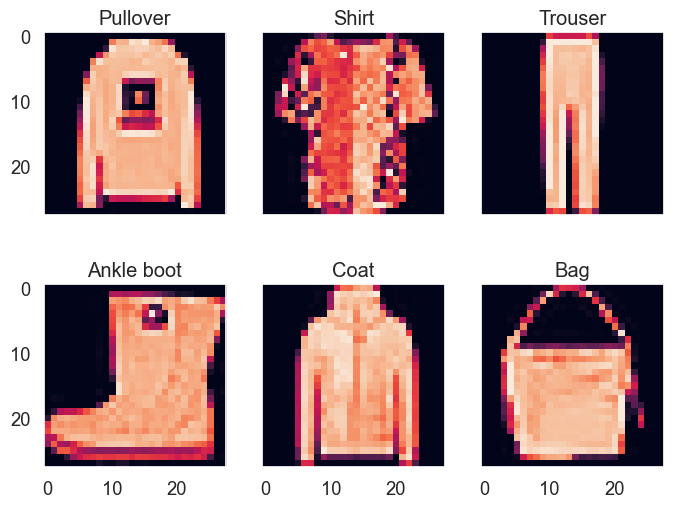

In [19]:
show_images(train_dataset)

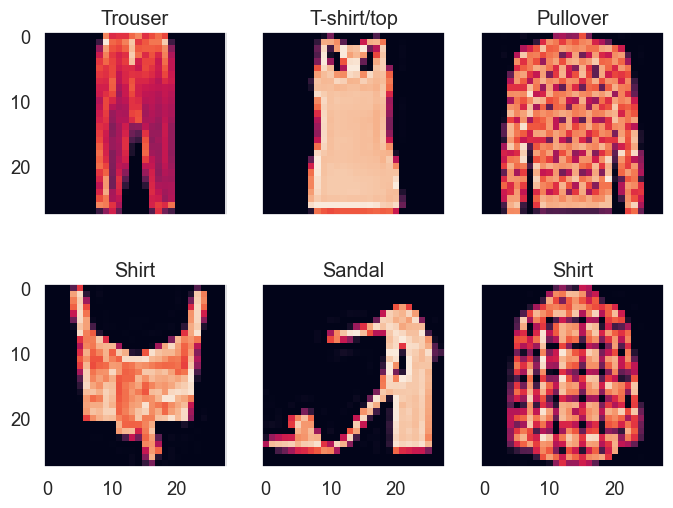

In [20]:
show_images(test_dataset)

Epoch 15 of 15 took 26.024s
  training loss (in-iteration): 	0.516534
  validation loss (in-iteration): 	0.532778
  training accuracy: 			82.66 %
  validation accuracy: 			81.42 %


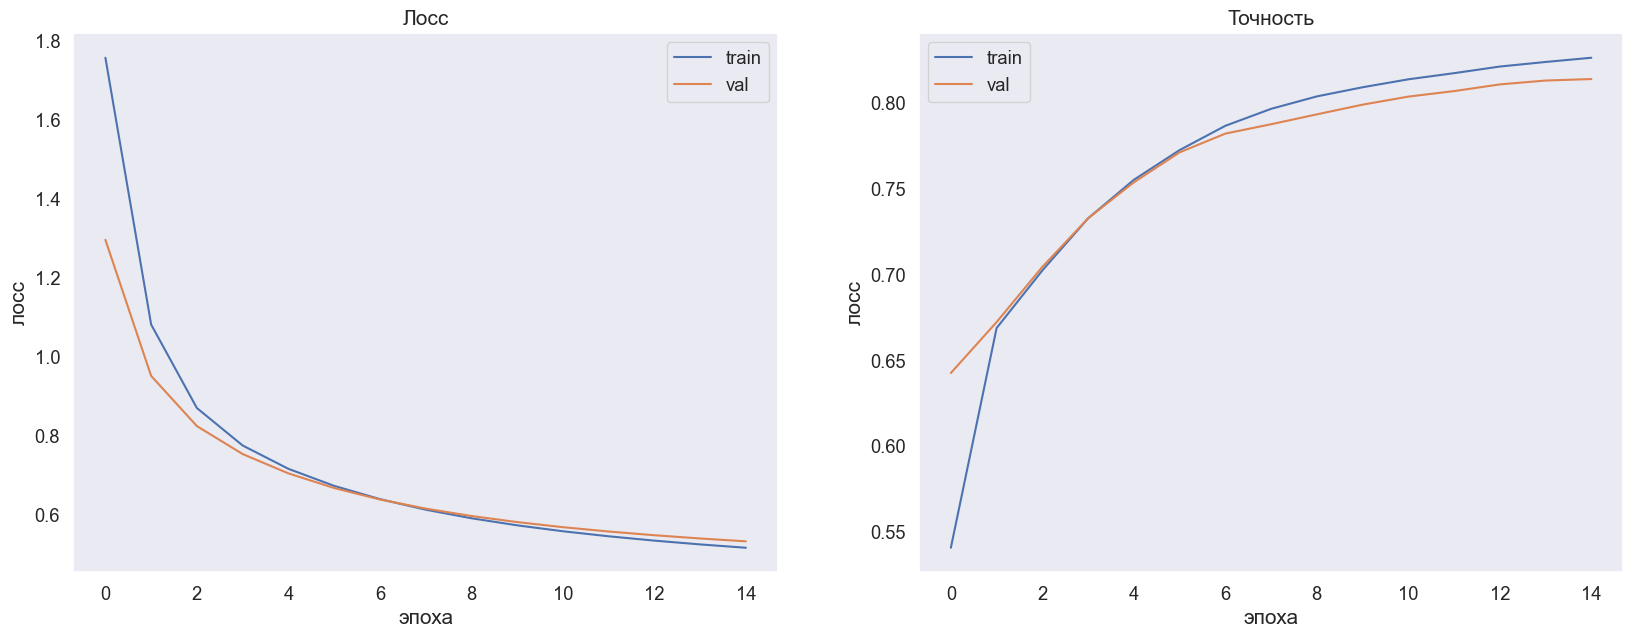

In [21]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch, test_batch, 
    num_epochs=15
)

# Получение состояния модели
model_state = model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "vebinar_dnn_weights"

# Сохранение весов в файл
torch.save(model_state, weights_path)

По итогу можно увидеть, что при архитектуре, которая может решать задачу классификации цифр (данная архитектура решает эту задачу с точностью в 90%), задачу классификации одежды, она решает чуть хуже, кроме того, примерно после 8-9 эпохи возникает опасность переобучения. Также мы видим, что максимальная тоночсть при данной архитектуре стремится к примерно 83%.

Чтобы попробовать улучшить качество, попробуем добавить еще 1 скрытый слой. Помимо этого, для эксперимента, попробуем увеличить learning rate.

Epoch 15 of 15 took 27.244s
  training loss (in-iteration): 	0.312663
  validation loss (in-iteration): 	0.367755
  training accuracy: 			88.59 %
  validation accuracy: 			86.71 %


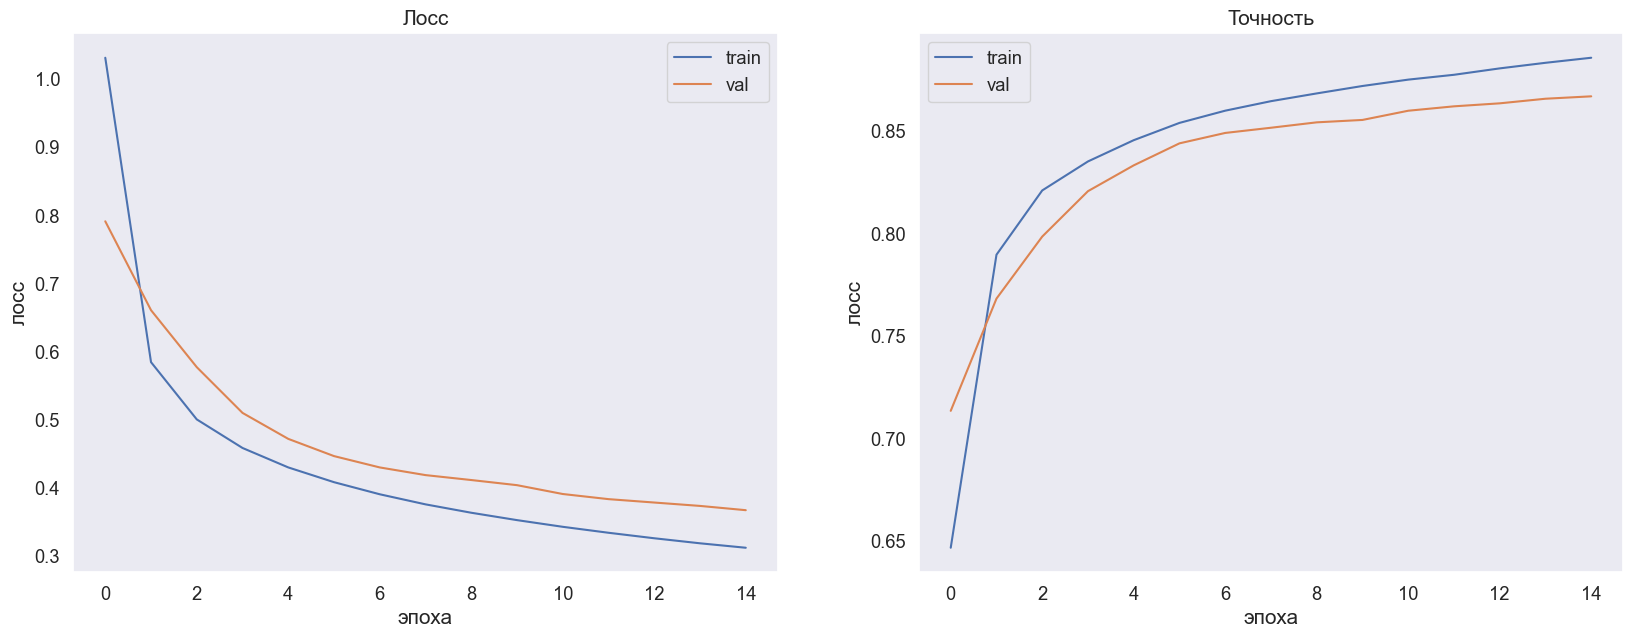

In [27]:
model2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
model2 = model2.to(device)

criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.1)

clf_model, history = train(
    model2, criterion2, optimizer2, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state2 = model2.state_dict()
weights_path2 = "more_powerful_model"
torch.save(model_state2, weights_path2)

Стало немного лучше, но можно еще лучше. Помимо этого, из-за увеличенного learning rate можно увидеть, что скорость схождения - быстрее. 

Что если попробовать использовать другой оптимизатор AdaGrad, который должен являться более усовершенствованным вариантом SGD.

Epoch 15 of 15 took 25.945s
  training loss (in-iteration): 	0.256822
  validation loss (in-iteration): 	0.402342
  training accuracy: 			90.37 %
  validation accuracy: 			87.25 %


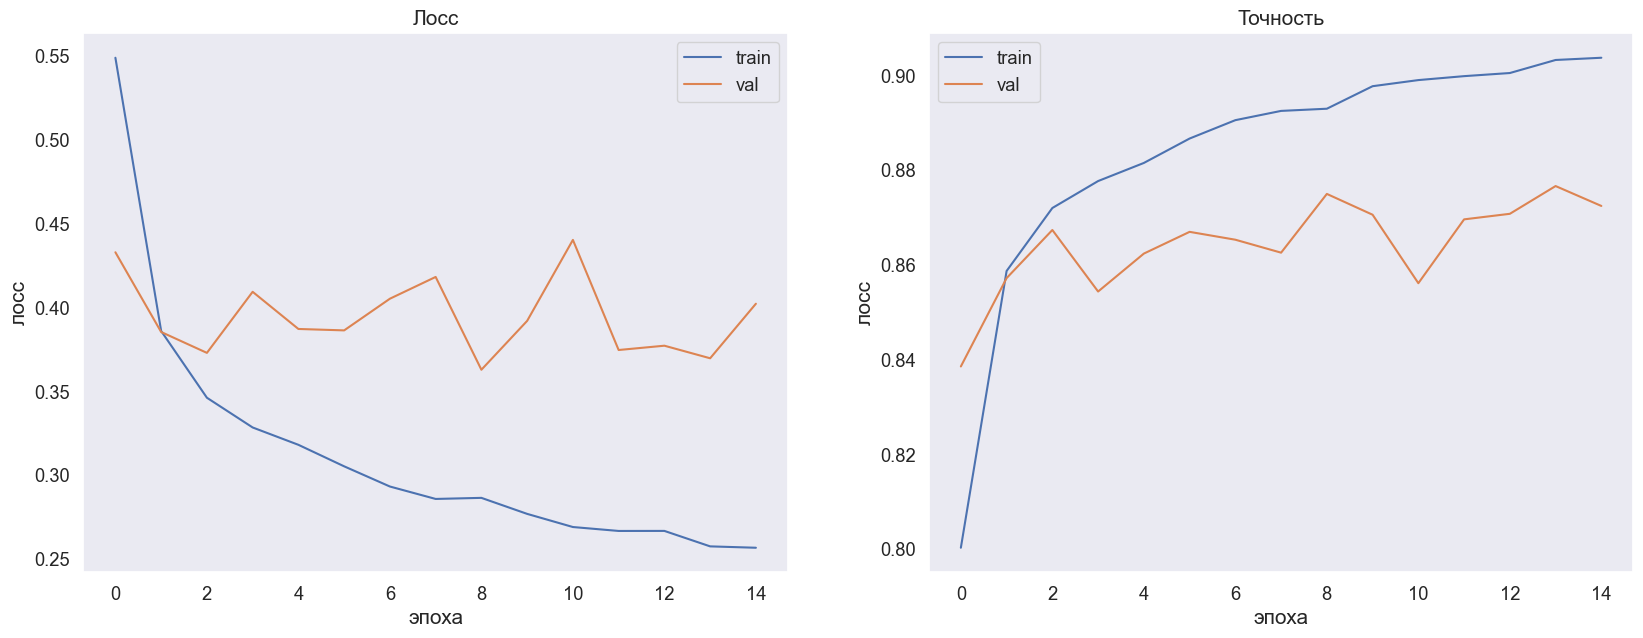

In [4]:
model3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
model3 = model3.to(device)

criterion3 = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)

clf_model, history = train(
    model3, criterion3, optimizer3, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state3 = model3.state_dict()
weights_path3 = "more_powerful_model_adam"
torch.save(model_state3, weights_path3)

Можно увидеть, что само по себе обучение ухудшилось, помимо этого, нейронная сеть, как мы видим благодаря скачкам, очень неустойчива.
Попробуем добавить дропаут и посмотреть, увеличиться ли устойчивость. Стоит помнить, что, благодаря дропауту, мы как бы из 1 нейронной сети, делаем несколько нейронных сетей, а значить нам нужно больше нейронов, помимо дропаута нужно допавить еще 1 скрытый слой.

Epoch 15 of 15 took 30.920s
  training loss (in-iteration): 	0.432685
  validation loss (in-iteration): 	0.395420
  training accuracy: 			84.53 %
  validation accuracy: 			85.63 %


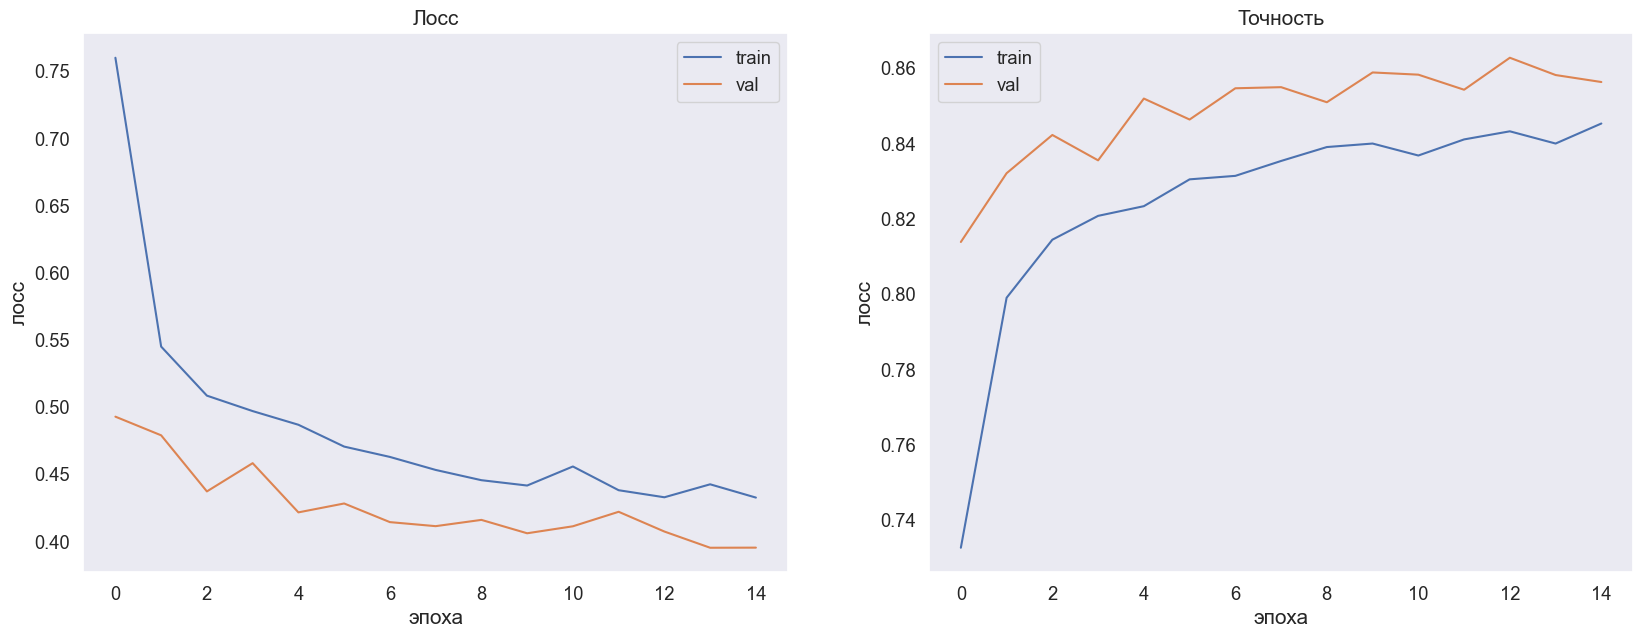

In [5]:
model4 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 2560),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(2560, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
model4 = model4.to(device)

criterion4 = torch.nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)

clf_model, history = train(
    model4, criterion4, optimizer4, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state4 = model4.state_dict()
weights_path4 = "more_powerful_model_adam_dropout"
torch.save(model_state4, weights_path4)

Epoch 15 of 15 took 27.939s
  training loss (in-iteration): 	0.338105
  validation loss (in-iteration): 	0.363135
  training accuracy: 			87.81 %
  validation accuracy: 			86.93 %


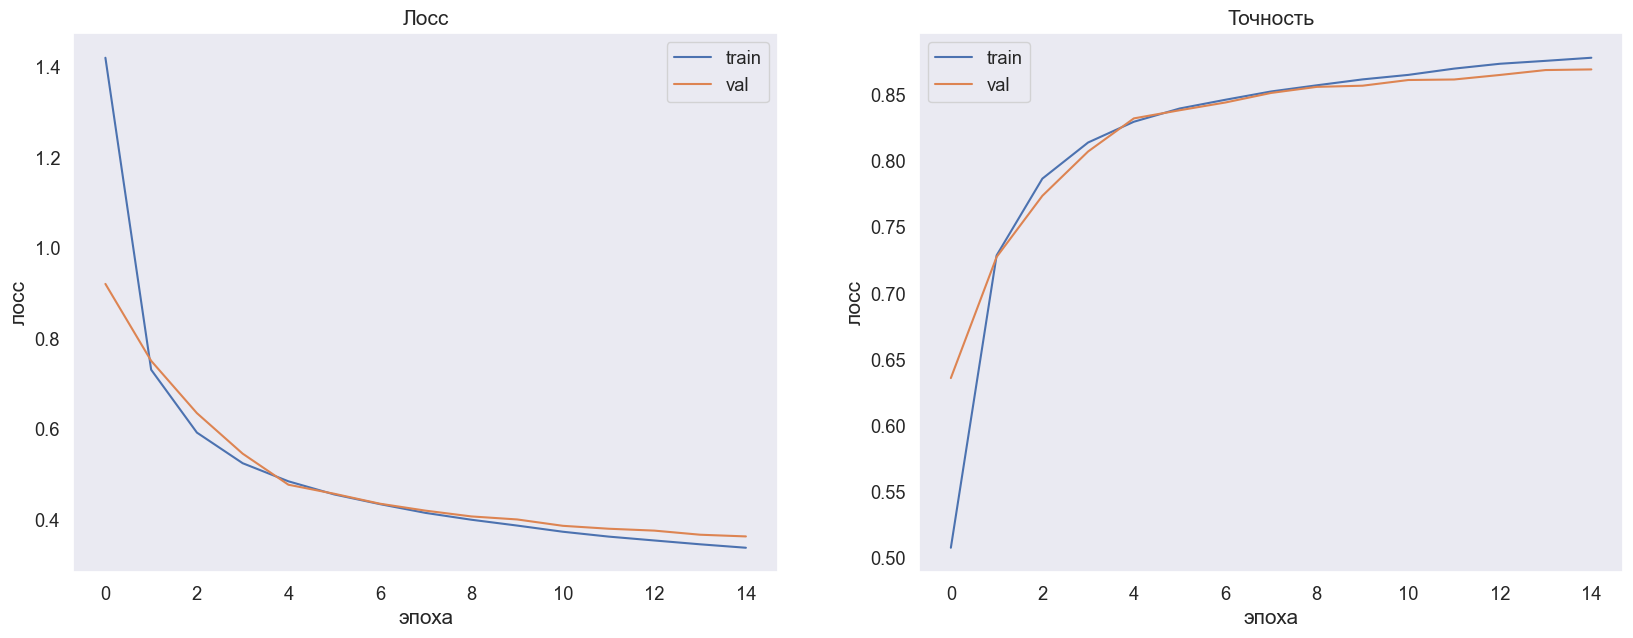

In [7]:
model5 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 2560),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(2560, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
model5 = model5.to(device)

criterion5 = torch.nn.CrossEntropyLoss()
optimizer5 = torch.optim.SGD(model5.parameters(), lr=0.05)

clf_model, history = train(
    model5, criterion5, optimizer5, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state5 = model5.state_dict()
weights_path5 = "more_powerful_model_KLDivLoss_dropout"
torch.save(model_state5, weights_path5)

Кажется, что все еще не хватает сложности модели для создания гиперповерхности, которая могла бы разделить данные. Попробуем добавить еще 1 скрытый слой.

Epoch 15 of 15 took 35.847s
  training loss (in-iteration): 	0.290132
  validation loss (in-iteration): 	0.329283
  training accuracy: 			89.30 %
  validation accuracy: 			88.24 %


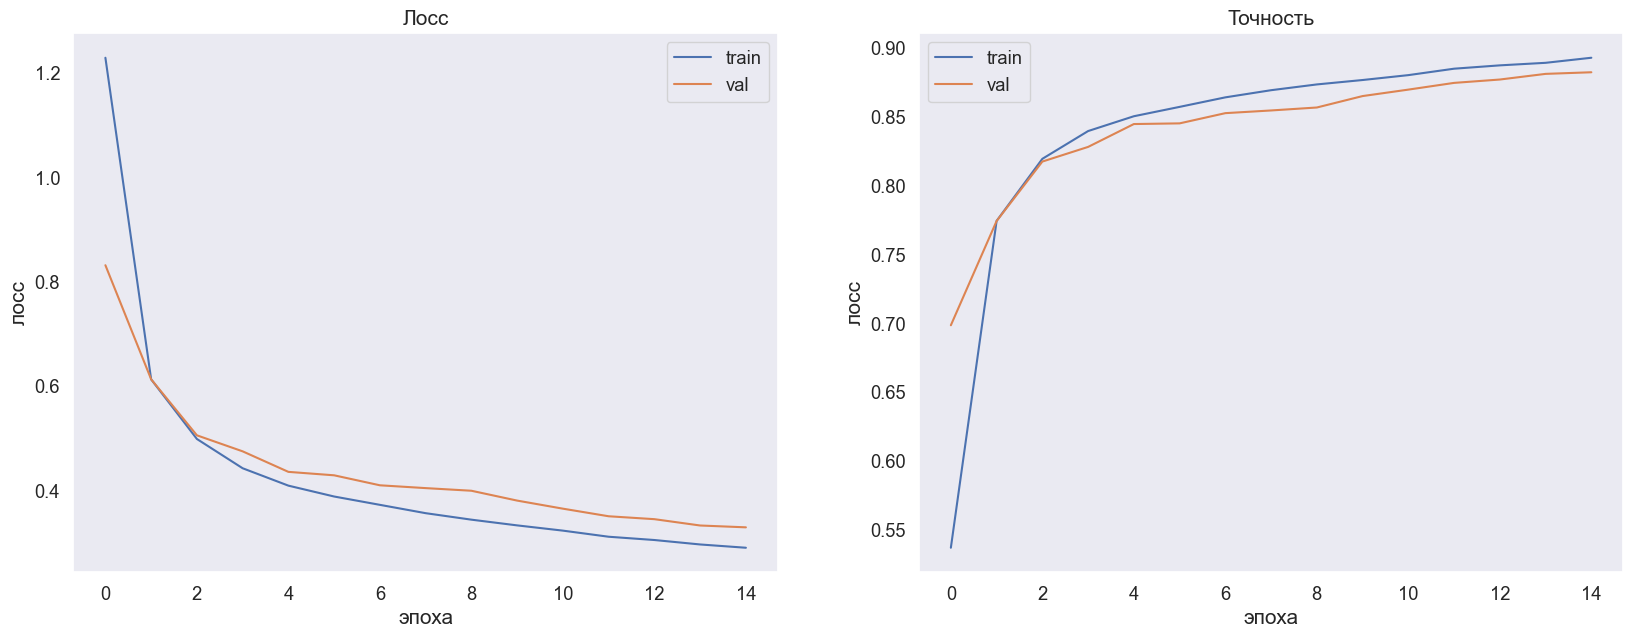

In [40]:
model6 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 2560),
    torch.nn.Linear(2560, 1280),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(1280, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
model6 = model6.to(device)

criterion6 = torch.nn.CrossEntropyLoss()
optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.1)

clf_model, history = train(
    model6, criterion6, optimizer6, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state6 = model6.state_dict()
weights_path6 = "more_powerful_model_dropout"
torch.save(model_state6, weights_path6)

Добавление слоя особо успехов не принесло, изменение оптимизатора и шага обучения приведет лишь к изменению скорости схождения, а для того, однако, можно увеличить кол-во эпох, так, как в целом потенциал для повышения точности еще есть. Чтобы повысить точность можно попробовать еще 1 способ - так как эта задача класификации изображений, можно попробовать добавить 1 сверточный слой и убрать часть нейроноы из линейных слоёв.

Epoch 15 of 15 took 30.660s
  training loss (in-iteration): 	0.278485
  validation loss (in-iteration): 	0.333222
  training accuracy: 			89.83 %
  validation accuracy: 			88.04 %


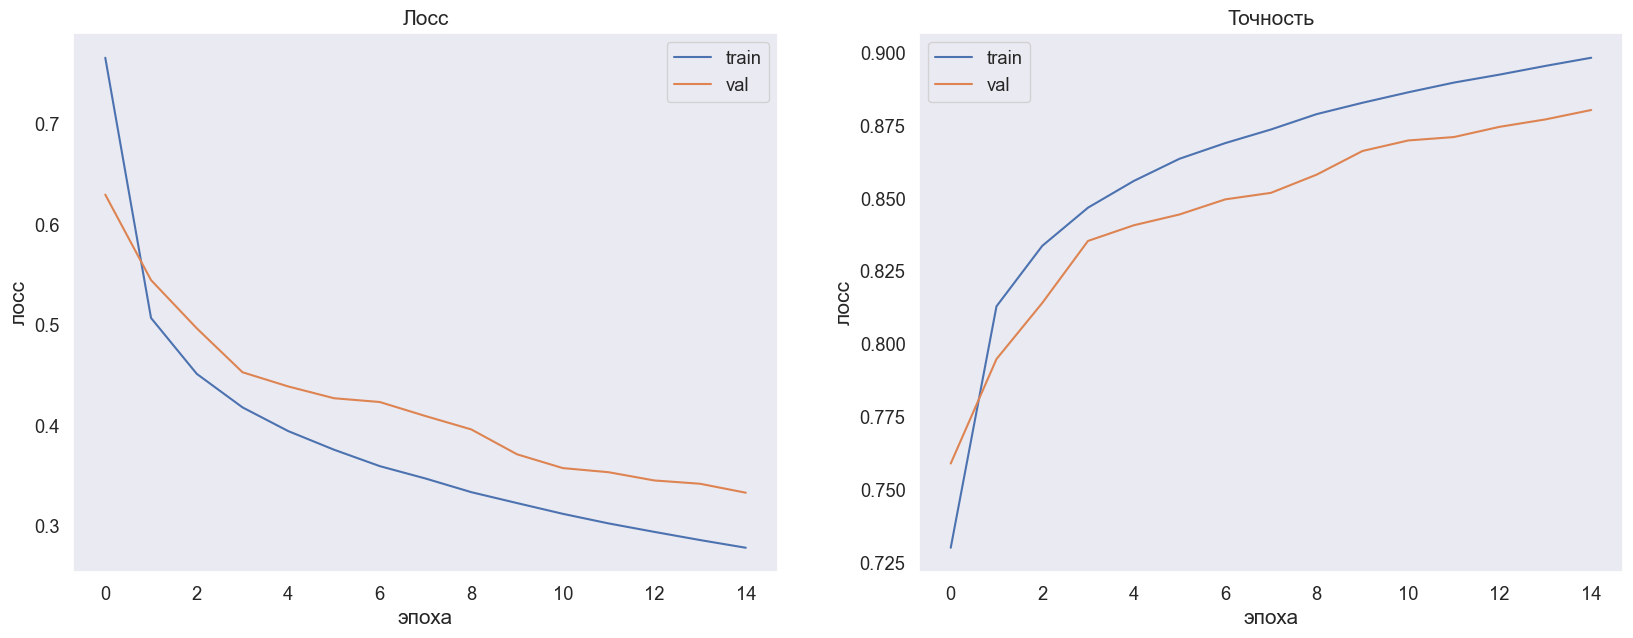

In [14]:
model7 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model7 = model7.to(device)

criterion7 = torch.nn.CrossEntropyLoss()
optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.05)

clf_model, history = train(
    model7, criterion7, optimizer7, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state7 = model7.state_dict()
weights_path7 = "more_powerful_model_convolution"
torch.save(model_state7, weights_path7)

Мы уменьшили модель, но при этом добавили 1 сверточный слой. Также можно заметить, что предел точности данной модели уже гораздо выше. Попробуем усложнить по аналогии с предыдущими экспериментами.

Epoch 15 of 15 took 43.742s
  training loss (in-iteration): 	0.313622
  validation loss (in-iteration): 	0.342370
  training accuracy: 			88.41 %
  validation accuracy: 			87.60 %


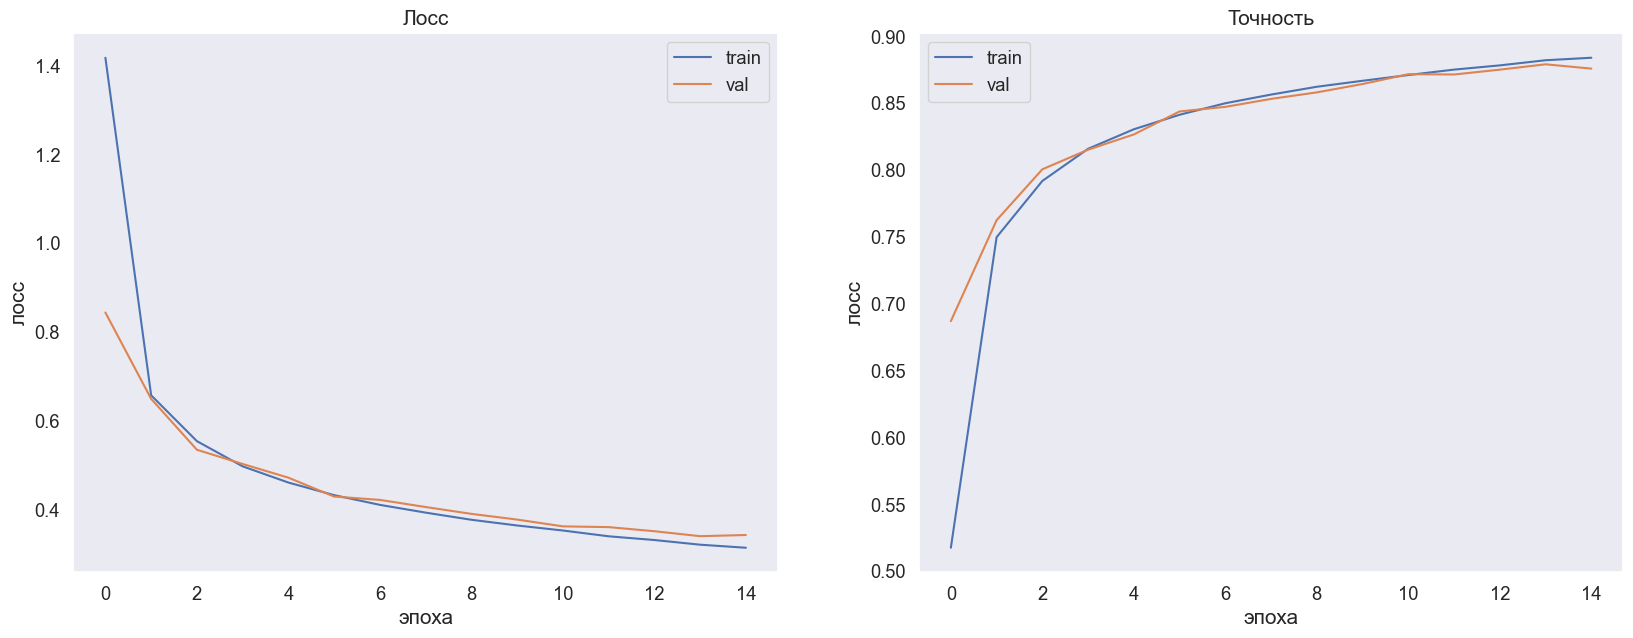

In [37]:
model8 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6272, 2560),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(2560, 1280),

    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
model8 = model8.to(device)

criterion8 = torch.nn.CrossEntropyLoss()
optimizer8 = torch.optim.SGD(model8.parameters(), lr=0.04)

clf_model, history = train(
    model8, criterion8, optimizer8, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state8 = model8.state_dict()
weights_path8 = "more_powerful_model_convolution_top"
torch.save(model_state8, weights_path8)

Попробуем сделать нейронную сеть еще сложнее, котрая вроде как должна работать лучше. Посмотрим - так ли это...

Epoch 15 of 15 took 57.106s
  training loss (in-iteration): 	1.653990
  validation loss (in-iteration): 	1.671558
  training accuracy: 			80.88 %
  validation accuracy: 			78.97 %


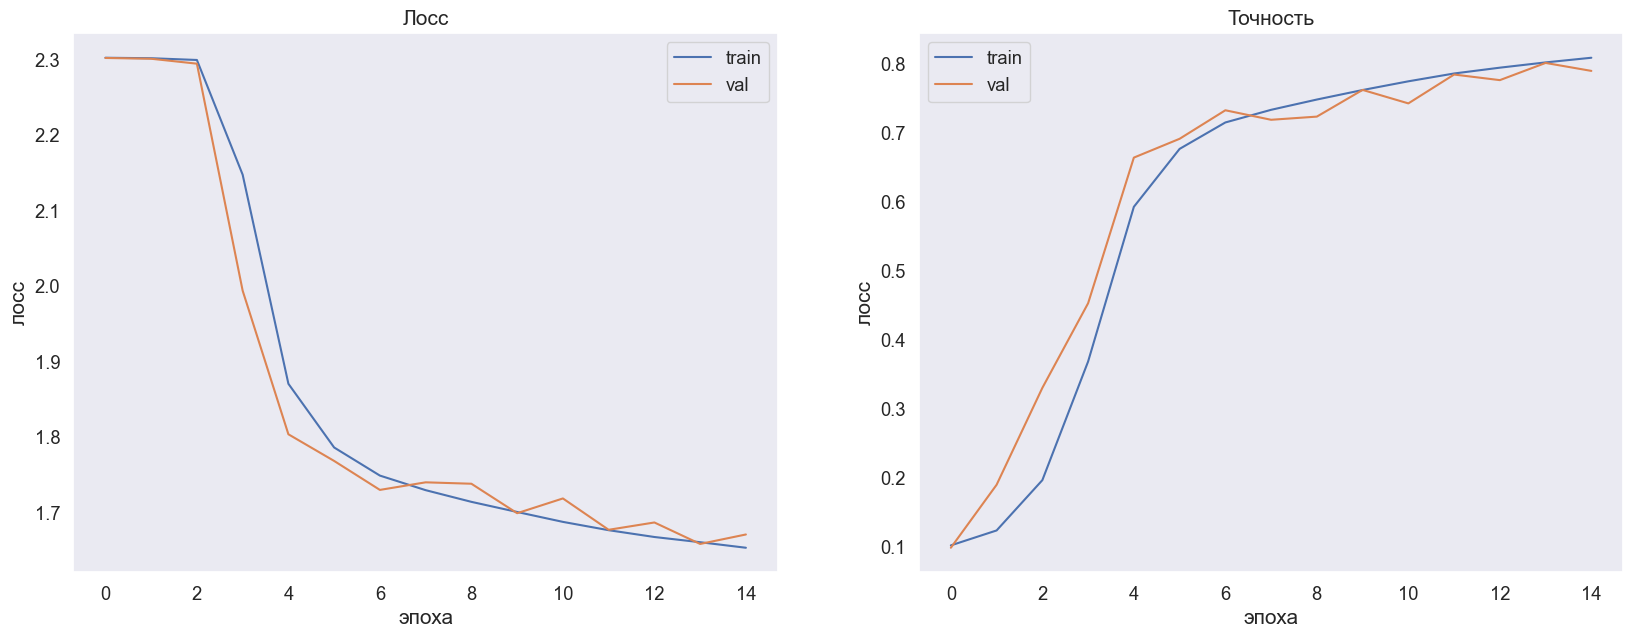

In [39]:
model9 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(2304, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10),
    nn.Softmax(dim=1)
)

model9 = model9.to(device)

criterion9 = torch.nn.CrossEntropyLoss()
optimizer9 = torch.optim.SGD(model9.parameters(), lr=0.1)

clf_model, history = train(
    model9, criterion9, optimizer9, 
    train_batch, test_batch, 
    num_epochs=15
)

model_state9 = model9.state_dict()
weights_path9 = "the_most_powerful_dnn"
torch.save(model_state9, weights_path9)

Получилось хуже. Сложнее - не значит лучше.